<h1>Emotion Analysis - Part 1</h1>
<h2><i>Data Preparation and Emotion Analysis with Text-Classification Model</i></h2>

<h3>[1.1][Imports]</h3>

In [133]:
### Imports ###
import re
from importlib.resources.readers import remove_duplicates

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from pandas.core.dtypes.common import infer_dtype_from_object
from datetime import datetime, timedelta
from plotly import hist_frame
style.use('ggplot')
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import json
import torch
from transformers import pipeline
from tqdm import tqdm
from itertools import pairwise
import pytz
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import f_oneway

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aklei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
### Set global variables ###

# Set execution type
RUN_TYPE = 0 # set to 1 to repeat file creation process

# Define Ekman's emotions 
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

<h3>[1.2][Data Preparation]</h3>
<p>Normalizing the quoted_tweets-dictionary to create a dataframe that contains the text of the quoted and origional tweet.</p>

In [135]:
### Prepare dataframe for analysis ### 
## Import dataset
df_tweets = pd.read_csv(
    '../data/twitter/tweets_isTweet.csv',
    dtype={'id': 'object'},
    low_memory=False
)
## Parameter for weighing emotions per event later in Event Study
df_tweets['total_engagement'] = (df_tweets['retweetCount'] +
                                 df_tweets['likeCount'] +
                                 df_tweets['replyCount'] +
                                 df_tweets['quoteCount'] +
                                 df_tweets['viewCount'])
df_tweets = df_tweets[['id', 'createdAt', 'text', 'quoted_tweet', 'total_engagement']]
df_tweets = df_tweets.rename(columns={'id': 'tweet_id', 'text': 'tweet_text'})

## Normalize json column
quoted_tweets_normalized = pd.json_normalize(
    df_tweets['quoted_tweet'].apply(
        lambda x: json.loads(x) if pd.notna(x) and isinstance(x, str) else None
    )
)
quoted_tweets_normalized = quoted_tweets_normalized.rename(columns={
    'id': 'quoted_tweet_id',
    'text': 'quoted_tweet_text'
})

## Link by index
df_tweets.index = quoted_tweets_normalized.index

## Concat both dataframes
df_tweets_normalized = pd.concat([
    df_tweets[['tweet_id', 'createdAt', 'tweet_text', 'total_engagement']],
    quoted_tweets_normalized[['quoted_tweet_id', 'quoted_tweet_text']]
], axis=1)

## View data
print(df_tweets.columns)
#df_tweets_normalized.head()

Index(['tweet_id', 'createdAt', 'tweet_text', 'quoted_tweet',
       'total_engagement'],
      dtype='object')


<h3>[1.3][Data Transformation]</h3>
<p>The following cell contains functions for the second step of data preparation, namely removing noise, truncating text, stemming words, and subsequently performing the emotion analysis.</p>

In [136]:
# Pre-process data for the analysis

## Classifier
### Load Hugging Face's emotion classifier
print("[Info]")
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None, device=0 if device == "cuda" else -1)

## Functions
### Removing noise from the text
def remove_noise(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+httpss\S+", '', text, flags=re.MULTILINE) # Remove Url
    text = re.sub(r"\@w+|\#", '', text) # remove @ and #
    text = re.sub(r"[^\w\s]", '', text) # remove punctuation
    text_tokens = text.split()
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

### Reduction of dimensionality by abstracting word to word stem and truncating text
stemmer = PorterStemmer()
def stem_words(text):
    words = text.split()
    stemmed_text = [stemmer.stem(word) for word in words]
    return stemmed_text

def truncate_text(text, max_length=512):
    words = text.split()
    return " ".join(words[:max_length])

### Computing and appending emotions to dataframe
def compute_emotions(text):
    if not isinstance(text, str) or text.strip() == "":
        print("[ComputeEmotions] Empty cell after data cleaning. Returning 0.0 for all emotions.")
        return {emotion: 0.0 for emotion in ekman_emotions}

    try:
        # Classify emotions using the Hugging Face pipeline and handle errors
        results = classifier(text)[0]
        if not results or not isinstance(results, list) or len(results[0]) == 0:
            return {emotion: 0.0 for emotion in ekman_emotions}

        emotion_scores = {result['label']: result['score'] for result in results}
        return {emotion: emotion_scores.get(emotion, 0.0) for emotion in ekman_emotions}

    except Exception as e:
        print(f"[ComputeEmotions] Error while processing text: {text[:20]}... Error: {e}")
        return {emotion: 0.0 for emotion in ekman_emotions}

def append_emotions(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    if text_column not in df.columns:
        raise ValueError(f"[AppendEmotions] Column '{text_column}' not found in DataFrame.")
    
    print("[AppendEmotions] Computing emotions for column:", text_column)

    cleaned_column = f"{text_column}_cleaned"
    df[cleaned_column] = df[text_column].apply(
        lambda x: " ".join(stem_words(remove_noise(x))) if isinstance(x, str) and x.strip() else ""
    )

    # Truncate text if cleaned text exceeds 512 tokens
    if (df[cleaned_column].str.split().str.len() > 512).any():
        print("[AppendEmotions] At least one row with more than 512 tokens - truncating text ...")
        df[cleaned_column] = df[cleaned_column].apply(lambda x: truncate_text(x, max_length=512))

    emotion_scores = [compute_emotions(text) for text in tqdm(df[cleaned_column], desc="[AppendEmotions] Processing emotions")]
    emotions_df = pd.DataFrame(emotion_scores)
    emotions_df.index = df.index
    emotions_df.columns = [f"{text_column}_{emotion}" for emotion in ekman_emotions]
    
    # Add dominant emotion column
    dominant = emotions_df.idxmax(axis=1).apply(lambda x: x.split('_')[-1])
    all_zero = emotions_df.eq(0.0).all(axis=1)
    dominant[all_zero] = np.nan
    emotions_df[f"{text_column}_dominant_emotion"] = dominant

    # Insert right hand of input text_column
    insert_at = df.columns.get_loc(text_column) + 1

    # DataFrame in drei Teile splitten und zusammenfügen
    left = df.iloc[:, :insert_at]
    right = df.iloc[:, insert_at:].drop(columns=[cleaned_column], errors='ignore')
    result_df = pd.concat([left, df[[cleaned_column]], emotions_df, right], axis=1)

    return result_df

[Info]


Device set to use cpu


<p>This part is only run once to create the new csv-file. Subsequently, the further analysis is performed on the new dataset.</p>

In [137]:
### Safe emotion analysis to file ###

# Perform emotion analysis for columns specified and safe as new csv-file
if RUN_TYPE == 1:
    for col in ['tweet_text']:#, 'quoted_tweet_text']:
        df_tweets_normalized = append_emotions(df_tweets_normalized, text_column=col)

    df_tweets_normalized.to_csv('../data/twitter/tweets_isTweet_emotions.csv', index=False)

<h1>Emotion Analysis - Part 2</h1>
<h2><i>Formatting & Data Exploration</i></h2>

<h3>[2.1][Data Formatting]</h3>

In [138]:
### Read necessary data and convert to the same timezone ###

# Set timezone 
eastern = pytz.timezone("US/Eastern")

#-- Tweet data --#
df_tweets_normalized = pd.read_csv('../data/twitter/tweets_isTweet_emotions.csv')[
    ['tweet_id',
     'createdAt',
     'total_engagement',
     'tweet_text_anger',
     'tweet_text_fear',
     'tweet_text_joy',
     'tweet_text_sadness',
     'tweet_text_disgust',
     'tweet_text_surprise',
     'tweet_text_dominant_emotion'
    ]
].dropna()

df_tweets_normalized = df_tweets_normalized.rename(
    columns={
        'tweet_id': 'id',
        'total_engagement': 'engagement',
        'createdAt': 'timestamp',
        'tweet_text_anger': 'anger',
        'tweet_text_fear': 'fear',
        'tweet_text_joy': 'joy',
        'tweet_text_sadness': 'sadness',
        'tweet_text_disgust': 'disgust',
        'tweet_text_surprise': 'surprise',
        'tweet_text_dominant_emotion': 'tweet_emotion'
    }
)

df_tweets_normalized['timestamp'] = pd.to_datetime(
    df_tweets_normalized['timestamp'],
    format="%a %b %d %H:%M:%S %z %Y",
    errors="coerce")

df_tweets_normalized['timestamp'] = df_tweets_normalized['timestamp'].dt.tz_convert(
    tz=eastern
)

#-- Stock data --#
df_stock_data = pd.read_csv('../data/stocks/tsla_intraday_202305_202504-1m.csv')

df_stock_data = df_stock_data.rename(
    columns={'Unnamed: 0': 'timestamp'}
)

df_stock_data['timestamp'] = pd.to_datetime(
    df_stock_data['timestamp']
).dt.tz_localize(
    tz=eastern
)

<h3>[2.2][Log Transformation]</h3>
<p>
    To analyse the fluctuations in return and volume, we use a logarithmized scale. This has some advantages:
    <!--
        Note for me:
        The return is the difference between prev and actual closing price:
        ln(actual/prev) = ln(actual) - ln(prev) // continuous returns are computed based on logarithmized price change
        For volume, we are interested in absolute values that where traded and not in relative changes, thus, we do not compare a actual and prev value. The volume can be 0 for some points in time, thus we must use log1p to cope with the case where log(0) would happen. Logarithmizing scales of the dispersed data to make it comparable.
        log1p(x) = log(1 + x) 
        => for small values of x, operates like a linear transformation
        => for large values of x, operates like a log transformation 
    -->
    <ul>
        <li>
            Stationary time-series: When observing the absolute trend, the price fluctuates and rises / falls over time (the mean changes over time). However, when looking at the changes per minute, the values fluctuate around a constant means.
        </li>
        <li>
            Additivity: By adding the log_returns (stationary values per minute), we can compute the overall effect within a time window. The single fluctuations around the constant mean add up to show a general fluctuation from a constant mean during the observed time window.
        </li>
        <li>
            Symmetry of up- and downwards trends: The return (relative change) is not symmetrical, the log_return is. In example:<br>
            return: 10 -> 11 = 1.1 ; 11 -> 10 = 0.91 <br>
            log_return: 10 -> 11 = 0.095 ; 11 -> 10 = -0.095
        </li>
        <li>Closer to being normally distributed (compared to absolute returns)
            <ul>
                <li>Central limit theorem: when adding many independent variables, their sum approximates a normal distribution</li>
                <li>Here: as trends are the sum of many independet factors, the sum of their deviation will approximate a normal distribution</li>
            </ul>
        </li>
    </ul>
</p>

In [139]:
### Calculating log values ###

# Get log return and log volume
df_stock_data['log_return'] = np.log(
    df_stock_data['close'] / df_stock_data['close'].shift(1)
)
df_stock_data['log_volume'] = np.log1p( # Using log1p to avoid issues with log(0), i.e., when no trades were made
    df_stock_data['volume']             # => log1p(x) = log(x + 1)
)

<h3>[2.3][Testing for Seasonality]</h3>
<p>
    Before analyzing whether or not we can observe a real effect of emotions on the stock, we must cancel out a possible bias, namely the intraday seasonality. The term describes the effect that the stock price / trading volume is influenced by the time of day, where the two metrics experience higher volatility at market opening and closing hours than during the day.
</p>
<p>
    To test for this effect, we must group the return / volume by the time of day and compare the means / variances of the groups. With the F-test we can check whether or not the mean values differ significantly between the different groups (here: hours of the day).
</p>
<p>
    To apply the F-test, we can use the f_oneway-Method, which tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples of two or more groups, possibly with different sizes. Here, it is applied to the data grouped by hours of the day and test whether the different goups (hours) have the same population mean. If a group mean significantly differs from the other groups means, we can conclude intraday effects.
</p>

In [140]:
### Examining intraday seasonality of fin data ###

# Calculate minute of day for stock data
df_stock_data['minute_of_day'] = df_stock_data['timestamp'].dt.hour * 60 + df_stock_data['timestamp'].dt.minute

# Compute intraday profile by grouping by minute of day
intraday_profile = df_stock_data.groupby('minute_of_day')[['log_return', 'log_volume']].agg(['mean', 'std']).reset_index()

[Intraday Profile] Visualization of intraday seasonality: Course of means per minute of day


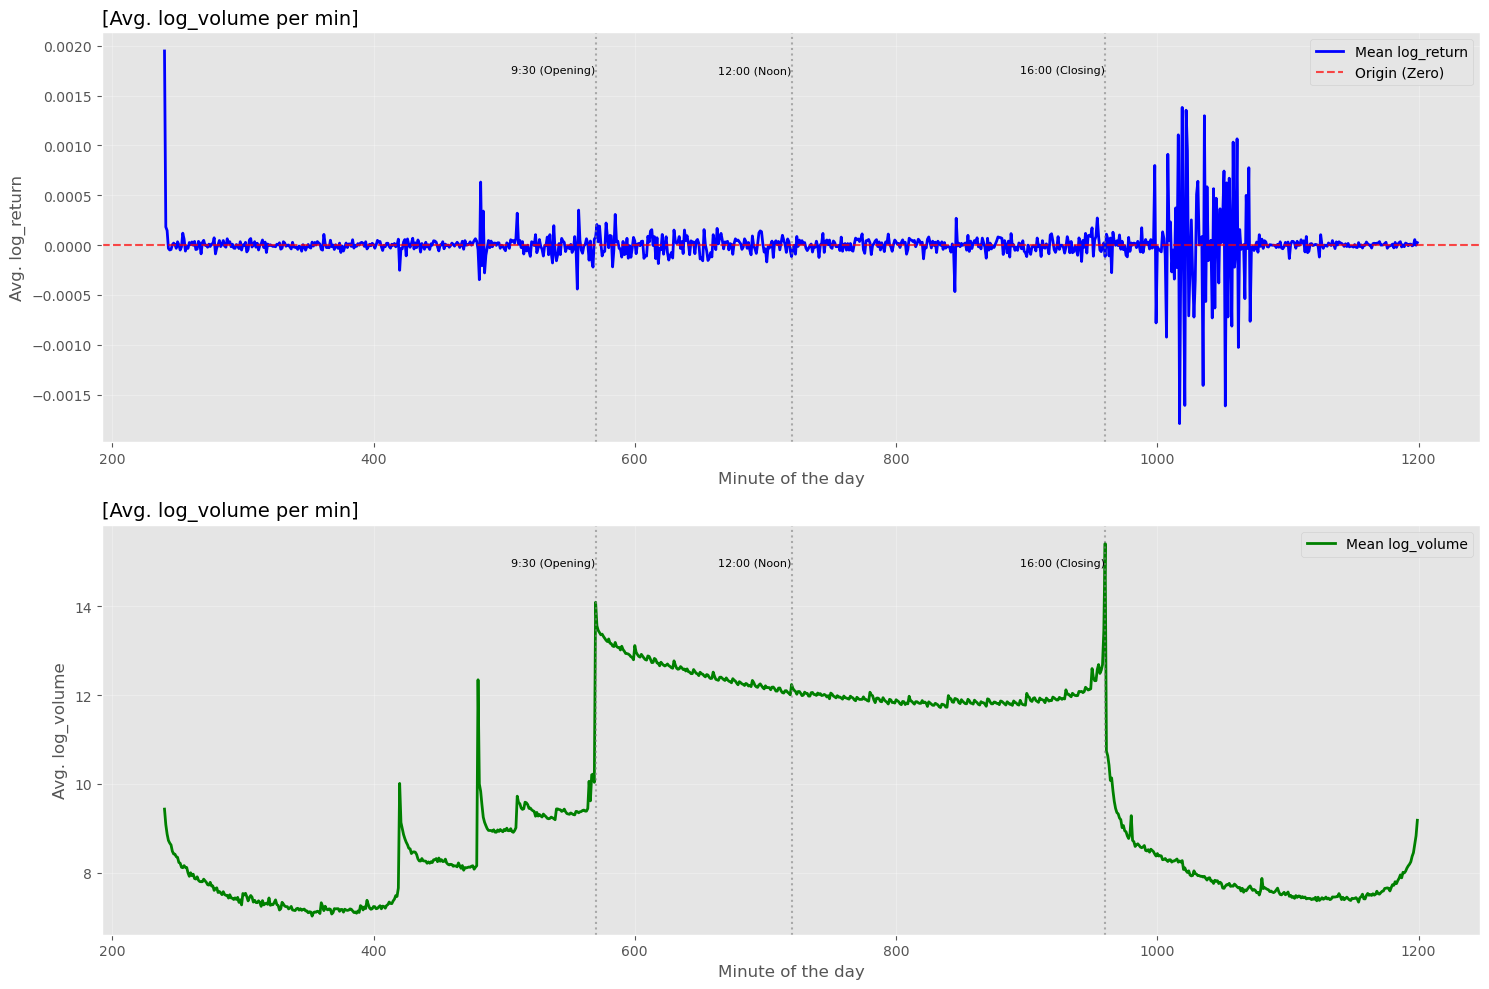

[Mean Stats] Intraday Profile of means of TSLA Stock Data
Log Return:
  - Min: -0.001792
  - Max: 0.001947
  - Span: 0.003739
Log Volume:
  - Min: 7.025
  - Max: 15.412
  - Span: 8.386

[Peak Times]
Lowest volume at: 5:53
Highest volume at: 16:00


In [141]:
### Plotting intraday profile of means ### 

print("[Intraday Profile] Visualization of intraday seasonality: Course of means per minute of day")

# Convert minute of the day to time_label 
intraday_profile['hour'] = intraday_profile['minute_of_day'] // 60
intraday_profile['minute'] = intraday_profile['minute_of_day'] % 60
intraday_profile['time_label'] = intraday_profile['hour'].astype(str) + ':' + intraday_profile['minute'].astype(str).str.zfill(2)

# Subplot with two y-axes for different scales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Log Return means
ax1.plot(intraday_profile['minute_of_day'], intraday_profile[('log_return', 'mean')], 
         color='blue', linewidth=2, label='Mean log_return')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Origin (Zero)')
ax1.set_title('[Avg. log_volume per min]', fontsize=14, loc='left')
ax1.set_xlabel('Minute of the day')
ax1.set_ylabel('Avg. log_return')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Market hours of NY Stock Exchange in eastern timezone 
market_times = {
    570: '9:30 (Opening)',
    720: '12:00 (Noon)', 
    960: '16:00 (Closing)'
}

# Plot 2: Log Volume means
ax2.plot(intraday_profile['minute_of_day'], intraday_profile[('log_volume', 'mean')], 
         color='green', linewidth=2, label='Mean log_volume')
ax2.set_title('[Avg. log_volume per min]', fontsize=14, loc='left')
ax2.set_xlabel('Minute of the day')
ax2.set_ylabel('Avg. log_volume')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Mark market hours in both plots
for ax in [ax1, ax2]:
    for minute, label in market_times.items():
        if minute in intraday_profile['minute_of_day'].values:
            ax.axvline(x=minute, color='gray', linestyle=':', alpha=0.6)
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.9
            ax.text(minute, y_pos, label, fontsize=8, ha='right')
            
plt.tight_layout()
plt.show()

# Stats
print(f"[Mean Stats] Intraday Profile of means of TSLA Stock Data")
print(f"Log Return:")
print(f"  - Min: {intraday_profile[('log_return', 'mean')].min():.6f}")
print(f"  - Max: {intraday_profile[('log_return', 'mean')].max():.6f}")
print(f"  - Span: {intraday_profile[('log_return', 'mean')].max() - intraday_profile[('log_return', 'mean')].min():.6f}")

print(f"Log Volume:")
print(f"  - Min: {intraday_profile[('log_volume', 'mean')].min():.3f}")
print(f"  - Max: {intraday_profile[('log_volume', 'mean')].max():.3f}")
print(f"  - Span: {intraday_profile[('log_volume', 'mean')].max() - intraday_profile[('log_volume', 'mean')].min():.3f}")

min_volume_time = intraday_profile.loc[intraday_profile[('log_volume', 'mean')].idxmin(), 'time_label']
max_volume_time = intraday_profile.loc[intraday_profile[('log_volume', 'mean')].idxmax(), 'time_label']

print(f"\n[Peak Times]")
print(f"Lowest volume at: {min_volume_time.iloc[0]}")
print(f"Highest volume at: {max_volume_time.iloc[0]}")

[Intraday Profile] Visualization of intraday seasonality: Volatility (std) per minute of day


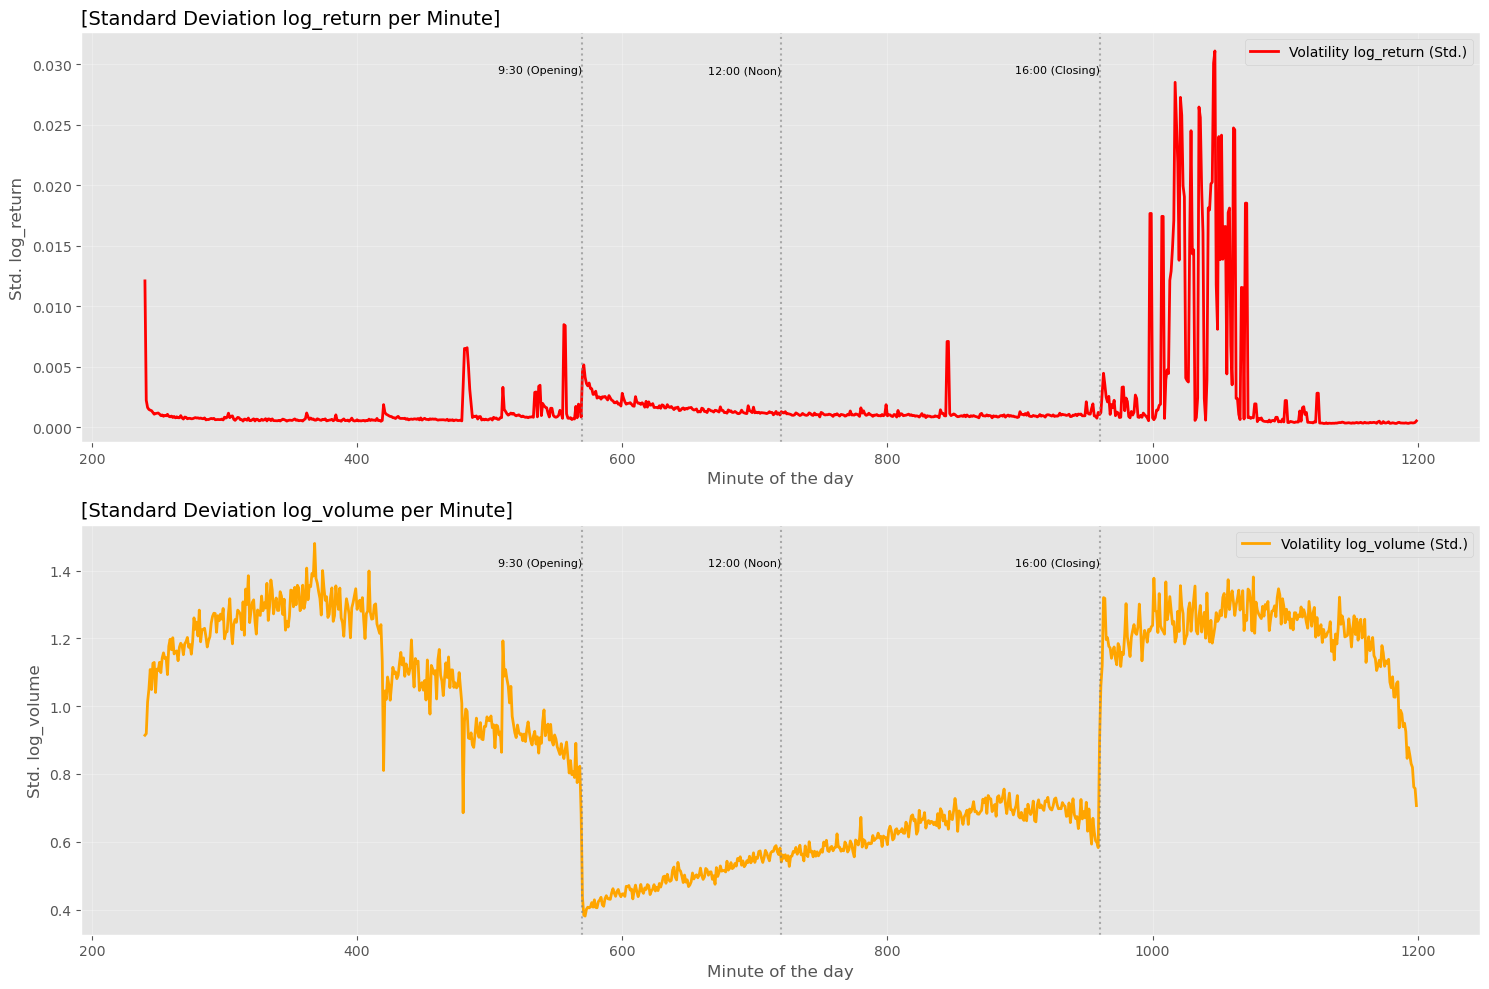

[Volatility Stats] Intraday Profile of Volatility (Std.) of TSLA Stock Data
Log Return Volatility:
  - Minimum Std: 0.000322
  - Maximum Std: 0.031102
  - Proportion Max/Min: 96.58x

Log Volume Volatility:
  - Minimum Std: 0.381
  - Maximum Std: 1.480
  - Proportion Max/Min: 3.88x

[Peak Times]
Lowest Return-Volatility at: 18:52
Highest Return-Volatility at: 17:27

[Statistical Test for Intraday Seasonality]
F-Test for log_return for hours: F=0.192, p=0.999685
F-Test for log_volume for hours: F=105216.055, p=0.000000

With α = 0.05:
Detected significant intraday differences for log_returns: No
Detected significant intraday differences for log_volumes: Yes


In [142]:
### Plotting volatility (std) of log return / volume and perform F-test ###

print("[Intraday Profile] Visualization of intraday seasonality: Volatility (std) per minute of day")

# Subplot with two y-axes for different scales
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Log Return volatility
ax1.plot(intraday_profile['minute_of_day'], intraday_profile[('log_return', 'std')], 
         color='red', linewidth=2, label='Volatility log_return (Std.)')
ax1.set_title('[Standard Deviation log_return per Minute]', fontsize=14, loc='left')
ax1.set_xlabel('Minute of the day')
ax1.set_ylabel('Std. log_return')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Log Volume Volatility
ax2.plot(intraday_profile['minute_of_day'], intraday_profile[('log_volume', 'std')], 
         color='orange', linewidth=2, label='Volatility log_volume (Std.)')
ax2.set_title('[Standard Deviation log_volume per Minute]', fontsize=14, loc='left')
ax2.set_xlabel('Minute of the day')
ax2.set_ylabel('Std. log_volume')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Mark market hours in both plots
for ax in [ax1, ax2]:
    for minute, label in market_times.items():
        if minute in intraday_profile['minute_of_day'].values:
            ax.axvline(x=minute, color='gray', linestyle=':', alpha=0.6)
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.9
            ax.text(minute, y_pos, label, fontsize=8, ha='right')

plt.tight_layout()
plt.show()

# Volatility stats
print(f"[Volatility Stats] Intraday Profile of Volatility (Std.) of TSLA Stock Data")
print(f"Log Return Volatility:")
print(f"  - Minimum Std: {intraday_profile[('log_return', 'std')].min():.6f}")
print(f"  - Maximum Std: {intraday_profile[('log_return', 'std')].max():.6f}")
print(f"  - Proportion Max/Min: {intraday_profile[('log_return', 'std')].max() / intraday_profile[('log_return', 'std')].min():.2f}x")

print(f"\nLog Volume Volatility:")
print(f"  - Minimum Std: {intraday_profile[('log_volume', 'std')].min():.3f}")
print(f"  - Maximum Std: {intraday_profile[('log_volume', 'std')].max():.3f}")
print(f"  - Proportion Max/Min: {intraday_profile[('log_volume', 'std')].max() / intraday_profile[('log_volume', 'std')].min():.2f}x")

min_vol_return_time = intraday_profile.loc[intraday_profile[('log_return', 'std')].idxmin(), 'time_label']
max_vol_return_time = intraday_profile.loc[intraday_profile[('log_return', 'std')].idxmax(), 'time_label']

print(f"\n[Peak Times]")
print(f"Lowest Return-Volatility at: {min_vol_return_time.iloc[0]}")
print(f"Highest Return-Volatility at: {max_vol_return_time.iloc[0]}")

# Test for Seasonality
# Group data by hours and test for differences
df_stock_data['hour'] = df_stock_data['minute_of_day'] // 60
hourly_returns = [group['log_return'].dropna() for name, group in df_stock_data.groupby('hour')]
hourly_volumes = [group['log_volume'].dropna() for name, group in df_stock_data.groupby('hour')]

# F-test for equality of variances over the hours
if len(hourly_returns) > 2:  # At least 3 groups for F-Test, * marks a series of groups
    f_stat_returns, p_val_returns = f_oneway(*hourly_returns)
    f_stat_volumes, p_val_volumes = f_oneway(*hourly_volumes)
    
    print(f"\n[Statistical Test for Intraday Seasonality]")
    print(f"F-Test for log_return for hours: F={f_stat_returns:.3f}, p={p_val_returns:.6f}")
    print(f"F-Test for log_volume for hours: F={f_stat_volumes:.3f}, p={p_val_volumes:.6f}")
    
    alpha = 0.05
    print(f"\nWith α = {alpha}:")
    print(f"Detected significant intraday differences for log_returns: {'Yes' if p_val_returns < alpha else 'No'}")
    print(f"Detected significant intraday differences for log_volumes: {'Yes' if p_val_volumes < alpha else 'No'}")

<p><i>Intraday Seasonality Test Results</i></p>
<p>Log_return
    <ul>
        <li>Results: No significant intraday seasonality observable</li>
        <li>Implications: No need to incorporate the time of day in our analysis of the log return</li>
    </ul>
</p>
<p>Log_volume
    <ul>
        <li>Results: Significant intraday seasonality observable - time of the day has effect on trading volume</li>
        <li>Implications: Must include the effect into our analysis</li>
        <li>How: intraday z-normalization of log_volume</li>
    </ul>

In [143]:
### Computing log return/volume ###

df_stock_data['log_return_z'] = (df_stock_data['log_return'] - df_stock_data['log_return'].mean()) / df_stock_data['log_return'].std()

df_stock_data['log_return_z_intraday'] = df_stock_data.groupby('minute_of_day')['log_return'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Volume
df_stock_data['log_volume'] = np.log(
    df_stock_data['volume']+1
)

df_stock_data['log_volume_z_intraday'] = df_stock_data.groupby('minute_of_day')['log_volume'].transform(
    lambda x: (x - x.mean()) / x.std()
)

#print("[Stock]\n", df_stock_data.head())

<h3>[2.4][Normalization]</h3>
<p>
    To evaluate whether an event has a significant effect on the return / volume, we must check if the mean from the event-window (point in time or timeframe) significantly differentiates from the mean of the estimation window, which we use as baseline for comparison. This can be done by performing a t-test, however, this presumes the variable to be normally distributed.
</p>
<p>
    By plotting the log_return and log_volume we can see, that the log_return already is approximately normally distributed. The log_volume however incorporates the seasonality. By observing the two peaks we can tell that more extreme values occur more frequently and that consequently the variable is not normally distributed (can be lead back to higher volume at beginning / end of trading day).
</p>
<p>
    To even out the intraday seasonality we must offset each log_volume against those that occur at the exact same time on different days. Hence, we must group the data by time of the day first and use this groups mean and standard deviation to perform a intraday z-normalization. By doing so, we receive a plot that nicely shows a normally distributed variable (code above, plot below).
</p>

Log Return]


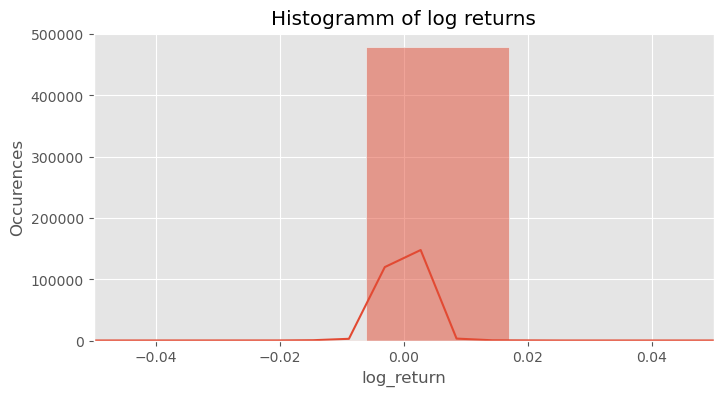

[Log Volume]


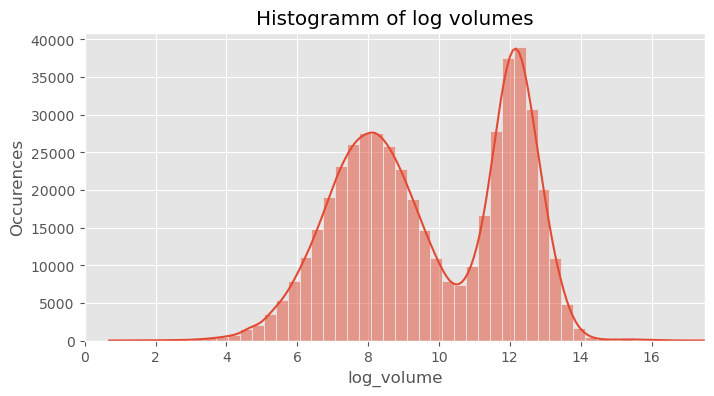

[z-Normalized Intraday Log Volume]


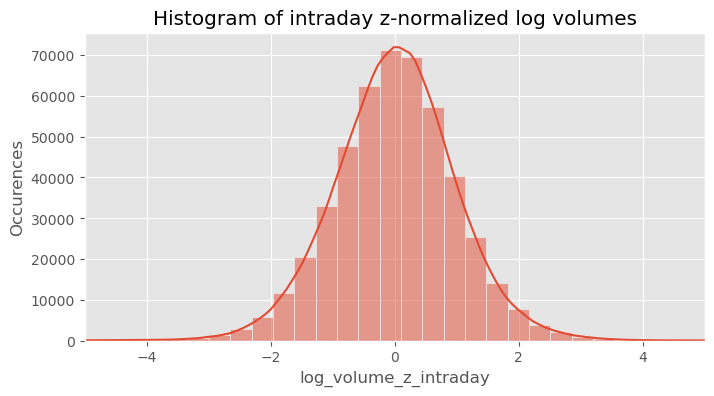

In [144]:
# Show histplot with curve of log returns and intraday z-normalized log volumes
## log_return
print("Log Return]")
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_return'].dropna(), bins=50, kde=True)
plt.title('Histogramm of log returns')
plt.xlabel('log_return')
plt.xlim([-0.05, 0.05])
plt.ylabel('Occurences')
plt.show()

## log_volume
print("[Log Volume]")
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_volume'].dropna(), bins=50, kde=True)
plt.title('Histogramm of log volumes')
plt.xlabel('log_volume')
plt.xlim([0, 17.5])
plt.ylabel('Occurences')
plt.show()

## log_volume_z_intraday
print("[z-Normalized Intraday Log Volume]")
plt.figure(figsize=(8, 4))
sns.histplot(df_stock_data['log_volume_z_intraday'].dropna(), bins=50, kde=True)
plt.title('Histogram of intraday z-normalized log volumes')
plt.xlabel('log_volume_z_intraday')
plt.xlim([-5, 5])
plt.ylabel('Occurences')
plt.show()



<p>
    <i>Implications of Normalization</i>
</p>
<p>
    In general, the z-transformation makes it possible to compare a single volume to all other volumes, independent of the time of the day. The intraday z-transformation however also takes the volatility of the time of the day into account and comares a single volume, that occurs at a certain time of the day, to all other volumes that occured at the same time of the day. This makes it possible to find effects beyond the temporal volatility. However, when interpreting the results, we must remember that each temporal group has its own standard deviation. 
</p>
<p>
    As the log_return already is approximately normally distributed, we do not need to normalize manually and can compute the metrics and compare it to the baseline (estimation window). 
    The log_volume still inherits the intraday effects however. To eliminate this distortion, we must group the log volumes by the minute of the day and z-normalize based on this groups mean and standard deviation. By doing so, it is now more difficult to compute the CAV, AAV, and CAAV. More on this later...
</p>

<h1>Emotion Analysis - Part 3</h1>
<h2><i>Event Study</i></h2>
<h3>[3.1][Data Preparation]</h3>
<p>
    Grouping tweets to events and assigning a weighted event emotion.
</p>
<ul>
    <li>Filter stock data by market hours</li>
    <li>Group tweets with diff < 7h to an event</li>
    <li>Assign weighed event emotions based on engagement</li>
</ul>

In [145]:
### Group tweets to events with dominant emotion ###

## Pre-process tweets for event study
# 1. Filter out tweets outside market hours (+-2h)
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time >= pd.to_datetime("04:00").time()
]
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time <= pd.to_datetime("17:59").time()
]

# 2. Sort by time
df_tweets_normalized = df_tweets_normalized.sort_values("timestamp").reset_index(drop=True)

# 3. Compute time difference between tweets
df_tweets_normalized['time_diff'] = df_tweets_normalized['timestamp'].diff()

# 4. Cluster Tweets to events with time_diff >= 7h
df_tweets_normalized['new_event'] = df_tweets_normalized['time_diff'] > pd.Timedelta(hours=7)

# 5. Cumulate events in event_id
df_tweets_normalized['event_id'] = df_tweets_normalized['new_event'].cumsum()

# 6. Compute the dominant emotion for each event and merge back to df
def compute_event_emotion(group):
    total_engagement = group['engagement'].sum()
    weighted_emo_scores = {
        emotion: (group[emotion] * group['engagement']).sum() / total_engagement
        for emotion in ekman_emotions
    }
    event_emotion = max(weighted_emo_scores, key=weighted_emo_scores.get)
    return pd.Series({
        **weighted_emo_scores,
        'event_emotion': event_emotion
    })

if not ('event_emotion' in df_tweets_normalized.columns):
    df_event_emotions = (df_tweets_normalized
        .drop(columns=['event_id'])
        .groupby(df_tweets_normalized['event_id'], group_keys=False)
        .apply(compute_event_emotion)
        .reset_index()
    )

    df_tweets_normalized = (df_tweets_normalized
        .merge(
            df_event_emotions[['event_id', 'event_emotion']],
            on='event_id',
            how='left'
        )
        .drop(columns={'anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise', 'tweet_emotion', 'new_event'})
    )
df_tweets_normalized.head()

# 8. Set event from time to time of the earliest tweet (models from what point in time a reaction can occur)
df_tweets_normalized['event_time'] = df_tweets_normalized.groupby('event_id')['timestamp'].transform('min')

# 9. Filter duplicate events
df_tweets_normalized = df_tweets_normalized.drop_duplicates(subset=['event_id'])

print("[Info] Number of unique events = ", df_tweets_normalized['event_id'].nunique(), "\n")

[Info] Number of unique events =  691 



<h3>[3.2][Create Event Study Dataframes]</h3>
<p>
    In this step, the event data is processed as follows:
</p>
<ul>
    <li>Event timestamps are aligned with the subsequent stock data timestamp. Hence, they are rounded and assigned to the next full minute.</li>
    <li>Events that do not have a full 5h history of estimation trading data are sorted out.</li>
    <li>Events that do not have a full 2h event window of trading data ahead are sorted out.</li>
    <li>Events, whose estimation or event window exceed the trading day, are sorted out (in alignment to the previous two points).</li>
</ul>
<p>
    (!!) Additionally, the abnormal return is calculated for both return and volume (also intraday z-normalized)
</p>

In [146]:
### Create/Read Event Study DataFrame ###

# 1. Filter events based on overlaps, estimation and observation windows
# 2. Calculate expected and abnormal returns for each event
def filter_events(df, get_pre = 0):
    # Define necessary vars
    est = 300
    obs = 120
    gap = est + obs
    results = []

    # 1. Filter by Overlaps
    valid_events = []
    last_event = None

    # Add valid events to the list
    for date in df.index:
        # First event always valid
        if last_event is None:
            valid_events.append(date)
            last_event = date
        else:
            # If timeshift > gaps, keep the current event and set as new last_event
            if (date - last_event) > pd.Timedelta(minutes=gap):
                valid_events.append(date)
                last_event = date

    # Only keep valid events
    df = df.loc[valid_events]
    print(f"[Overlap] New df_length = {len(df)}")

    # 2. Align event_time with the next available trading timestamp
    df.index = df.index.tz_convert(eastern)

    for i, date in enumerate(df.index):
        if date not in df_trades.index:
            future_times = df_trades.index[df_trades.index > date]
            if not future_times.empty:
                df.index.values[i] = pd.Timestamp(future_times[0])

    # 3. Filter events without sufficient estimation_window data
    # 4. Filter events without sufficient event_window data
    valid_events = []

    for date in df.index:
        day_data = df_trades[df_trades.index.date == date.date()]
        event_index = day_data.index.get_loc(date)

        remaining = len(day_data) - event_index

        if event_index >= est:
            if remaining >= obs:
                valid_events.append(date)

    df = df.loc[valid_events]
    print(f"[Sum Data] New df_length = {len(df)}")

    # 5. Event study variables
    for event_row in df.itertuples():
        event_id = event_row.event_id
        event_emo = event_row.event_emotion
        event_time = event_row.Index

        estimation_window = df_trades.loc[
            event_time - pd.Timedelta(minutes=est) : event_time - pd.Timedelta(minutes=1)
        ]
        event_window = df_trades.loc[
            event_time - pd.Timedelta(minutes=get_pre * est): event_time + pd.Timedelta(minutes=obs - 1)
        ]

        expected_return = estimation_window['log_return'].mean()
        expected_volume = estimation_window['log_volume'].mean()
        expected_volume_z_intraday = estimation_window['log_volume_z_intraday'].mean()

        for i, fin_row in enumerate(event_window.itertuples()):
            if get_pre == 1:
                i = int((fin_row.Index - event_time).total_seconds() // 60)

            actual_return = fin_row.log_return
            abnormal_return = actual_return - expected_return

            actual_volume = fin_row.log_volume
            abnormal_volume = actual_volume - expected_volume

            actual_volume_z_intraday = fin_row.log_volume_z_intraday
            abnormal_volume_z_intraday = actual_volume_z_intraday - expected_volume_z_intraday

            results.append({
                'event_id': event_id,
                'event_fin_offset': i,
                'event_time': event_time,
                'fin_time': fin_row.Index,
                'event_emo': event_emo,
                'actual_return': actual_return,
                'expected_return': expected_return,
                'abnormal_return': abnormal_return,
                'actual_volume': actual_volume,
                'expected_volume': expected_volume,
                'abnormal_volume': abnormal_volume,
                'actual_volume_z_intraday': actual_volume_z_intraday,
                'expected_volume_z_intraday': expected_volume_z_intraday,
                'abnormal_volume_z_intraday': abnormal_volume_z_intraday
            })

    # Make a dataframe from the result list
    df_valid_events = pd.DataFrame(results)

    return df_valid_events

#  Create new dfs with necessary event data and set time column as index
df_events = (df_tweets_normalized[['event_id', 'event_emotion', 'event_time']]
             .set_index('event_time')
             .sort_index())
df_trades = (df_stock_data[['timestamp', 'log_return', 'log_volume', 'log_volume_z_intraday']]
              .set_index('timestamp')
              .sort_index())

if RUN_TYPE == 1:
    df_event_study = filter_events(df_events, get_pre = 0).to_csv('../data/twitter/emotion_event_study.csv', index=False)
    df_event_study_pre_post = filter_events(df_events, get_pre=1).to_csv('../data/twitter/emotion_event_study_pre_post.csv', index=False)

df_event_study = pd.read_csv('../data/twitter/emotion_event_study.csv')
df_event_study_pre_post = pd.read_csv('../data/twitter/emotion_event_study_pre_post.csv')

print(f"[Info] Event Study DataFrame has {len(df_event_study)} entries.")
print(df_event_study.columns, "\n")
print(f"[Info] Event Study Pre/Post DataFrame has {len(df_event_study_pre_post)} entries.")
print(df_event_study_pre_post.columns)

[Info] Event Study DataFrame has 38039 entries.
Index(['event_id', 'event_fin_offset', 'event_time', 'fin_time', 'event_emo',
       'actual_return', 'expected_return', 'abnormal_return', 'actual_volume',
       'expected_volume', 'abnormal_volume', 'actual_volume_z_intraday',
       'expected_volume_z_intraday', 'abnormal_volume_z_intraday'],
      dtype='object') 

[Info] Event Study Pre/Post DataFrame has 133047 entries.
Index(['event_id', 'event_fin_offset', 'event_time', 'fin_time', 'event_emo',
       'actual_return', 'expected_return', 'abnormal_return', 'actual_volume',
       'expected_volume', 'abnormal_volume', 'actual_volume_z_intraday',
       'expected_volume_z_intraday', 'abnormal_volume_z_intraday'],
      dtype='object')


<p><i>Resulting Dataframe</i></p>
<p>
    We get a dataframe that contains all events with their corresponding event_window (and estimation_window) tuples, containing offset and abnormal returns / volumes. With this, we can now compute our event study metrics.
</p>

[Info] Length of df_event_study: 38039 <= 38040



Text(0, 0.5, 'Number of Events (scaled)')

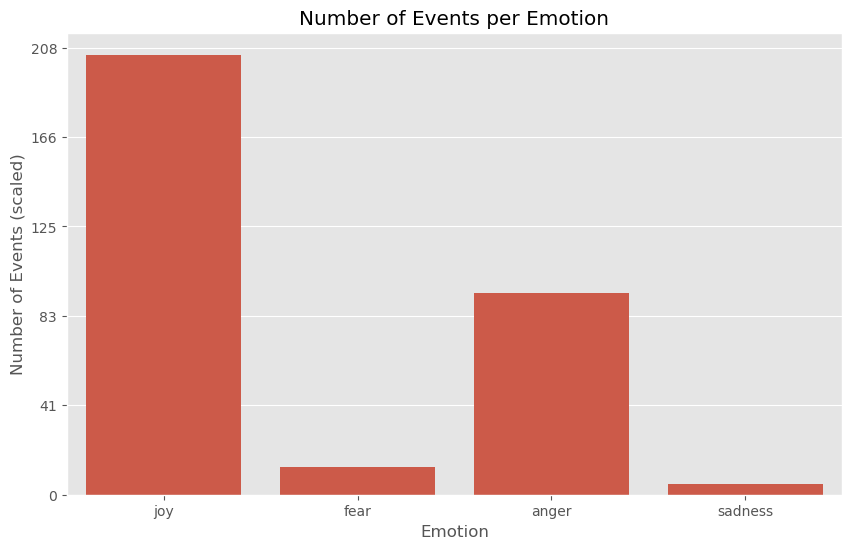

In [147]:
### Show histogram of Number of Events per Emotion ###

print(f"[Info] Length of df_event_study: {len(df_event_study)} <= {df_event_study['event_time'].nunique() * 120}\n")

def scale_formatter(x, pos):
    return f'{int(x / 120)}'

plt.figure(figsize=(10, 6))
sns.countplot(x='event_emo', data=df_event_study)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
plt.title('Number of Events per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Events (scaled)')

<h3>[3.2][Event Study on Return]</h3>
<h5><u>3.2.1 Abnormal Return: Investigating short term impact by offset</u></h5>
<p>[Intro]</p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in stock return can be observed by the minute<br>
--> Is the mean abnormal return significantly greater / lower than 0 resp. does the mean abnormal return significantly differ from the expected return?</p>
<p>
    <ul>
        <li>H0: mean abnormal return = 0</li>
        <li>H1: mean abnormal return >< 0</li>
    </ul>
</p>

In [148]:
### Significance Testing of AR ###

print(f"[Info] Testing for significant effect of emotions {df_event_study['event_emo'].unique()} on abnormal returns ...")

## Functions
def stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''
    
def test_abnormal_returns(df, test_col):
    results = []

    emotions = df['event_emo'].unique()
    minutes = df['event_fin_offset'].unique()

    for minute in minutes:
        row = {'minute': minute}

        for emo in emotions:
            values = df.loc[
                (df['event_fin_offset'] == minute) & (df['event_emo'] == emo),
                test_col
            ]
            if len(values) > 1:
                t_stat, p_value = stats.ttest_1samp(values, 0)
                row[f'{emo}_{test_col}_mean'] = values.mean()
                row[f'{emo}_{test_col}_t_stat'] = t_stat
                row[f'{emo}_{test_col}_p_value'] = p_value
                row[f'{emo}_{test_col}_sig'] = f"{t_stat:.2f}{stars(p_value)}" # adds stars 
            else:
                row[f'{emo}_{test_col}_mean'] = np.nan
                row[f'{emo}_{test_col}_t_stat'] = np.nan
                row[f'{emo}_{test_col}_p_value'] = np.nan
                row[f'{emo}_{test_col}_sig'] = ''
        
        results.append(row)
    return pd.DataFrame(results)

## Test abnormal returns and visualize results

# Test the abnormal returns for each emotion and minute
ar_test_scores = test_abnormal_returns(df_event_study, 'abnormal_return')
ar_test_scores.set_index('minute', inplace=True)

# Show only rows with significant p-values
alpha = 0.05

# Make list of p-value columns
pval_cols = [col for col in ar_test_scores.columns if col.endswith('_p_value')]

# Keep only rows where at least one p-value is below alpha
significant_rows = ar_test_scores[(ar_test_scores[pval_cols] < alpha).any(axis=1)]

# Show significant rows
sig_cols = [col for col in significant_rows.columns if col.endswith('_sig')]
significant_rows[sig_cols]

[Info] Testing for significant effect of emotions ['joy' 'fear' 'anger' 'sadness'] on abnormal returns ...


,joy_abnormal_return_sig,fear_abnormal_return_sig,anger_abnormal_return_sig,sadness_abnormal_return_sig
minute,,,,
1,-2.21**,-1.13,-0.44,-0.78
27,-0.86,3.98***,0.25,-0.15
34,-1.30,-0.80,-3.74***,-0.89
56,1.63,2.34**,-1.15,0.55
61,2.01**,-0.39,2.50**,0.20
67,1.15,-2.52**,1.73*,-0.99
79,-2.03**,-0.90,-0.91,0.93
100,-1.63,-0.77,2.42**,1.34
101,-1.11,-0.94,-2.06**,-0.50


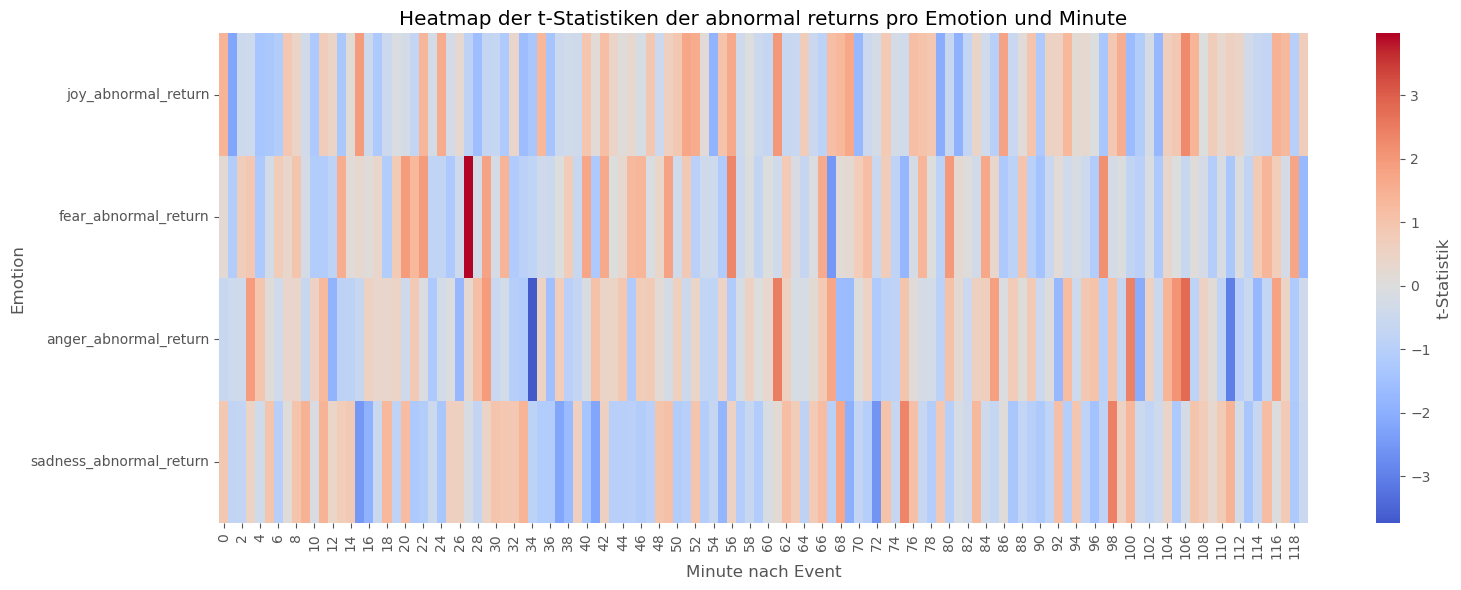

In [149]:
### Plot Heatmap of t-Statistics for Abnormal Returns ###

# Emotionen extrahieren (alle Spalten mit '_t_stat' am Ende)
emotions = [col.replace('_t_stat', '') for col in ar_test_scores.columns if col.endswith('_t_stat')]

# DataFrame für Heatmap vorbereiten: Zeilen = Emotionen, Spalten = Minuten
heatmap_data = pd.DataFrame({
    emo: ar_test_scores[f"{emo}_t_stat"] for emo in emotions
}).T  # Transponieren: Emotionen als Zeilen

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={'label': 't-Statistik'}
)
plt.xlabel("Minute nach Event")
plt.ylabel("Emotion")
plt.title("Heatmap der t-Statistiken der abnormal returns pro Emotion und Minute")
plt.tight_layout()
plt.show()

<p>[Test-Results]</p>
<p><i>What was tested?</i></p>
<p>For each emotion and each minute in the post-event window it was tested if the mean abnormal return significantly deviates from 0. The goal was to detect whether there is a deviation from the expected return (H0: mean = 0).</p>
<p><i>Results</i></p>
<p>The heatmap shows that only for few points across the emotions, a significant effect could be observed, where the mean abnormal return significantly deviates from 0. Thus, the H1: mean >< 0 can most likely be refused.
    <ul>
        <li>No consistent pattern of significant observations visible, that may indicate a recurrent effect.</li>
        <li>There are a few significant events across the heatmap. Because of their low density they can probably be declared as outliers.</li>
    </ul>
</p>
<p><i>Conclusion</i></p>
<p>In the short-term and for individual points in time, an impact of a tweets emotion on the expected return of the stock can be neglected.</p>

<h5><u>3.2.2 Cumulative Abnormal Return</u></h5>
<p>
    [Intro]
</p>
<p>
    In the following it is analysed, whether an effect occurs within specified time windows. As log returns are additive, we can use the cumsum() Method to compute the cumulative sum and plot it over time. This way, we can yield a graph that shows the actual return over time and how the abnormal return deviates after the event.
</p>

[Info] Plotting cumulative log returns for emotion: joy


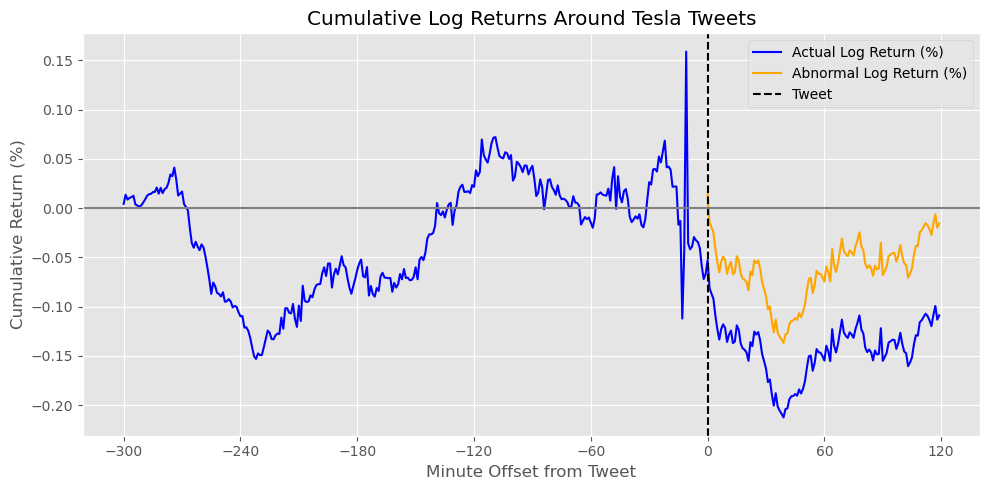

[Info] Cumulative Abnormal Return (CAR) for joy over the event window: -0.0154 %

[Info] Plotting cumulative log returns for emotion: fear


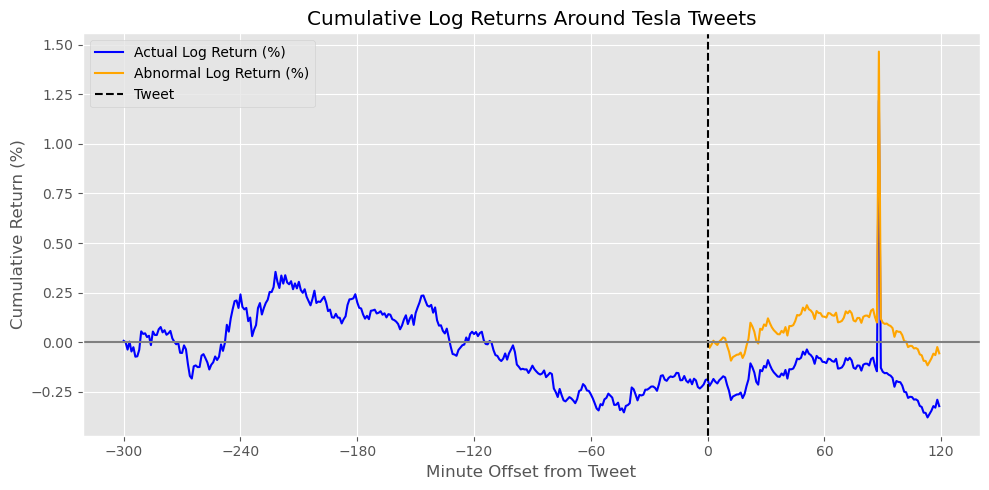

[Info] Cumulative Abnormal Return (CAR) for fear over the event window: -0.0564 %

[Info] Plotting cumulative log returns for emotion: anger


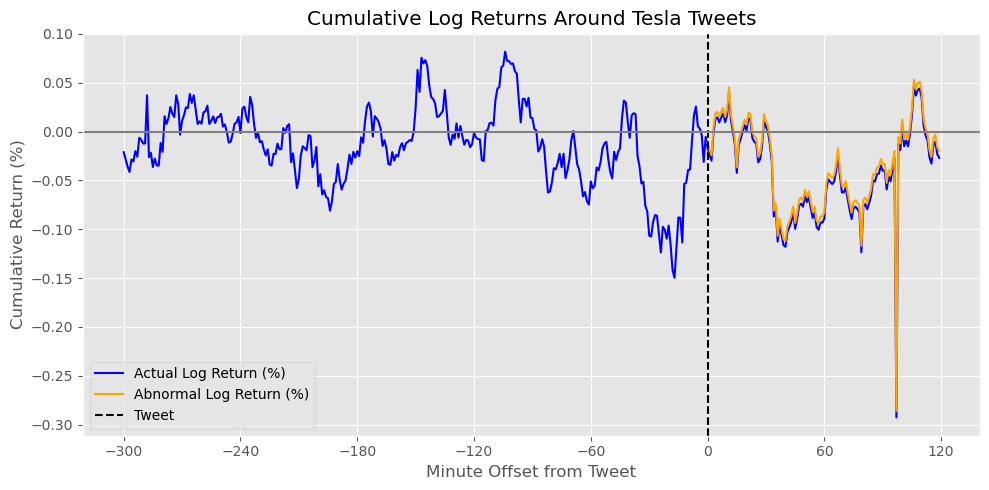

[Info] Cumulative Abnormal Return (CAR) for anger over the event window: -0.0199 %

[Info] Plotting cumulative log returns for emotion: sadness


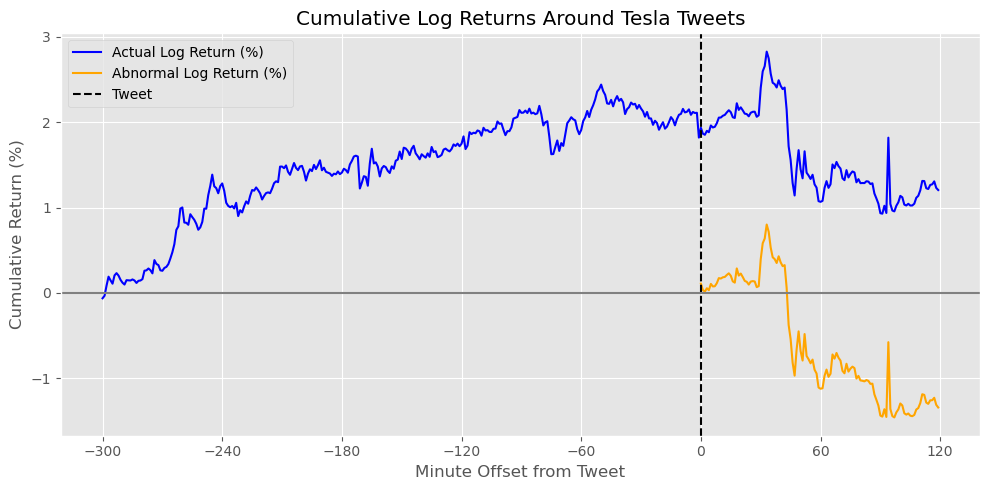

[Info] Cumulative Abnormal Return (CAR) for sadness over the event window: -1.3429 %



In [150]:
### [All emotions] Plotting Cumulative Log Returns Around Tweets ###

# Present emotions in the DataFrame
emotions = df_event_study_pre_post['event_emo'].unique()

for emo in emotions:
    print(f"[Info] Plotting cumulative log returns for emotion: {emo}")

    # 0. Windows
    estimation_window = df_event_study_pre_post
    event_window = df_event_study_pre_post[df_event_study_pre_post['event_fin_offset'] >= 0]

    # 1. Calculate cumulative actual log returns around tweets
    actual_returns = estimation_window[estimation_window['event_emo'] == emo].groupby('event_fin_offset')['actual_return'].mean()
    cumulative_actual_return = actual_returns.cumsum()

    # 2. Caluculate cumulative abnormal log returns around tweets
    abnormal_returns = event_window[event_window['event_emo'] == emo].groupby('event_fin_offset')['abnormal_return'].mean()
    cumulative_abnormal_return = abnormal_returns.cumsum()

    # 3. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_actual_return.index, cumulative_actual_return.values * 100, label="Actual Log Return (%)", color="blue")
    plt.plot(cumulative_abnormal_return.index, cumulative_abnormal_return.values * 100, label="Abnormal Log Return (%)", color="orange")
    plt.axvline(0, linestyle="--", color="black", label="Tweet")
    plt.axhline(0, linestyle="-", color="gray")
    plt.title("Cumulative Log Returns Around Tesla Tweets")
    plt.xlabel("Minute Offset from Tweet")
    plt.xticks([-300, -240, -180, -120, -60, 0, 60, 120])
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print CAR over the event window
    car_correct = abnormal_returns.sum()  # Summe der rohen abnormal returns
    print(f"[Info] Cumulative Abnormal Return (CAR) for {emo} over the event window: {car_correct* 100:.4f} %\n")


In [151]:
### Test for significant effect of emotions on abnormal volume in window ###

windows = [(0, 1), (0, 2), (0, 5), (0, 10), (0, 30), (0, 60), (0, 120)]

results = []
for emo in emotions:
    print(f"[Info] Testing for significant effect of emotion '{emo}' on cumulative abnormal return")
    
    # Iterate through each time window and test for significant effects
    for start, end in windows:

        # Filter for the current emotion and time window
        emo_window = df_event_study[
            (df_event_study['event_emo'] == emo) &
            (df_event_study['event_fin_offset'] >= start) &
            (df_event_study['event_fin_offset'] <= end)
        ]
        
        # Compute CAR for each event
        event_car = emo_window.groupby('event_time')['abnormal_return'].sum()

        # Calculate mean CAR across all events
        mean_car = event_car.mean() 

        # Perform t-test against zero (significantly different from zero)
        t_stat, p_value = stats.ttest_1samp(event_car, 0)

        results.append({
            'emotion': emo,
            'window': f"[{start}, {end}]",
            'mean_car': f"{mean_car * 100:.4f} %",  # Convert to percentage
            't_stat': f"{round(t_stat, 2)}{stars(p_value)}",  # Add stars for significance
        })

df_car_results = pd.DataFrame(results)

for emo in df_car_results['emotion'].unique():
    print(f"\n[Info] Results for emotion '{emo}':")
    emo_results = df_car_results[df_car_results['emotion'] == emo]
    print(emo_results[['window', 'mean_car', 't_stat']])

[Info] Testing for significant effect of emotion 'joy' on cumulative abnormal return
[Info] Testing for significant effect of emotion 'fear' on cumulative abnormal return
[Info] Testing for significant effect of emotion 'anger' on cumulative abnormal return
[Info] Testing for significant effect of emotion 'sadness' on cumulative abnormal return

[Info] Results for emotion 'joy':
     window   mean_car  t_stat
0    [0, 1]  -0.0142 %   -0.82
1    [0, 2]  -0.0195 %   -0.91
2    [0, 5]  -0.0547 %  -1.94*
3   [0, 10]  -0.0667 %  -1.77*
4   [0, 30]  -0.0892 %    -1.4
5   [0, 60]  -0.0744 %   -0.94
6  [0, 120]  -0.0154 %   -0.15

[Info] Results for emotion 'fear':
      window   mean_car t_stat
7     [0, 1]  -0.0287 %  -0.92
8     [0, 2]  -0.0120 %  -0.31
9     [0, 5]  -0.0143 %  -0.27
10   [0, 10]  -0.0184 %  -0.24
11   [0, 30]   0.0816 %   0.49
12   [0, 60]   0.1285 %   0.71
13  [0, 120]  -0.0564 %  -0.15

[Info] Results for emotion 'anger':
      window   mean_car t_stat
14    [0, 1]  -0.0

<p><b>3.2 Abnormal Volume: Investigating short term impact by offset</b></p>
<p>In the following it is analysed to what extent a significant effect of a particular emotion on the change in trade volume can be observed by the minute<br>
--> Is the mean abnormal volume significantly greater / lower than 0 resp. does the mean abnormal volume significantly differ from the expected volume?</p>
<p>
    <ul>
        <li>H0: mean abnormal volume = 0</li>
        <li>H1: mean abnormal volume >< 0</li>
    </ul>
</p>
<p>Here, the absolute trading volume is logarithmized for each offset. However, as volume is interesting as an absolute value (how many stocks where traded), the value is always positive and may deviate a lot. Hence, the log_volume is not normally distributed (see Illustration below) and a t-test cannot be performed as it assumes a normal distribution of the variable.</p>
<p>Consequently, a z-transformation is performed on the log_volume to be able to properly test for significance.</p>

In [152]:
# Test volumes
av_test_scores_z_intraday = test_abnormal_values(df_event_study, 'abnormal_volume_z_intraday')
av_test_scores_z_intraday.set_index('minute', inplace=True)

# Show only rows with significant p-values
alpha = 0.05

pval_cols = [col for col in av_test_scores_z_intraday.columns if col.endswith('_p_value')]
# At least one significant p-value in the row
significant_rows = av_test_scores_z_intraday[(av_test_scores_z_intraday[pval_cols] < alpha).any(axis=1)]
sig_cols = [col for col in significant_rows.columns if col.endswith('_sig')]
significant_rows[sig_cols]

,joy_abnormal_volume_z_intraday_sig,fear_abnormal_volume_z_intraday_sig,anger_abnormal_volume_z_intraday_sig,sadness_abnormal_volume_z_intraday_sig
minute,,,,
1,0.26,-1.52,-1.64,2.97**
6,0.04,-1.13,-1.31,-3.43**
8,0.35,1.06,-2.38**,-0.56
10,1.31,0.35,-2.11**,-0.05
12,0.77,1.58,0.91,-2.96**
16,-0.04,-1.74,-2.24**,-2.74*
20,-0.69,0.88,-2.07**,-1.35
29,2.06**,0.37,0.66,-1.43
39,1.36,-0.19,1.25,3.49**


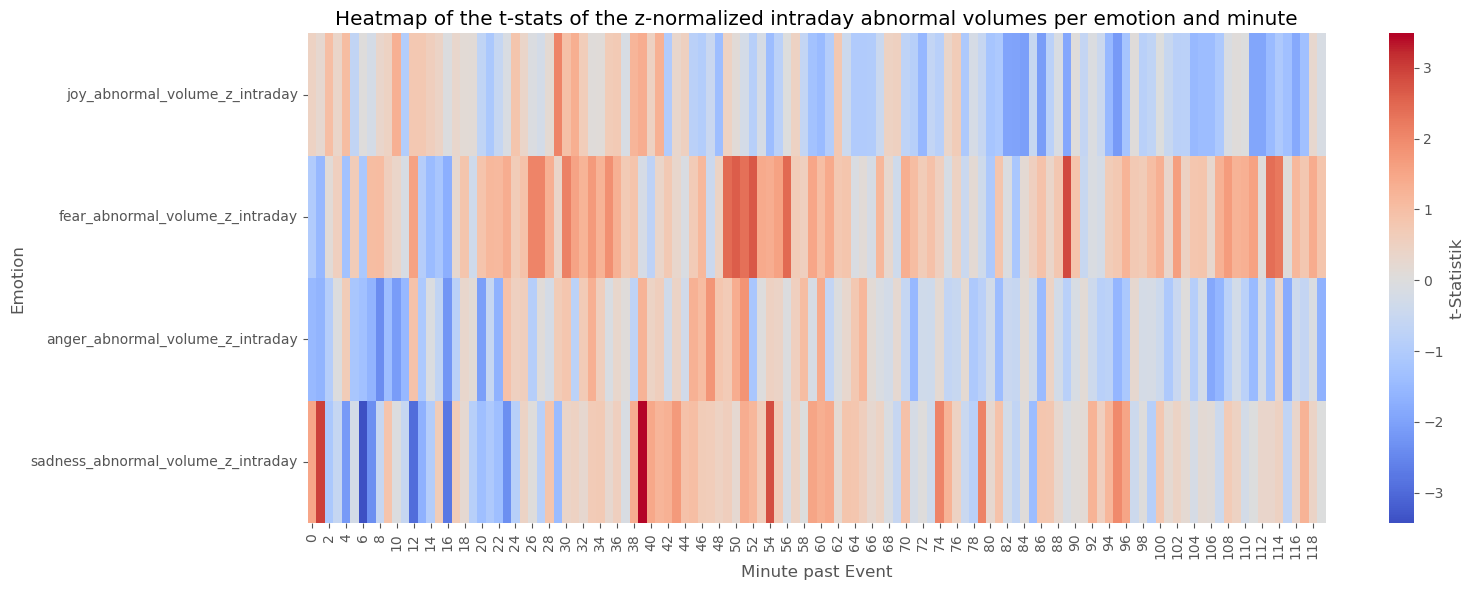

In [153]:
# Emotionen extrahieren (alle Spalten mit '_t_stat' am Ende)
emotions_vol = [col.replace('_t_stat', '') for col in av_test_scores_z_intraday.columns if col.endswith('_t_stat')]
heatmap_data_vol = pd.DataFrame({
    emo: av_test_scores_z_intraday[f"{emo}_t_stat"] for emo in emotions_vol
}).T

plt.figure(figsize=(16, 6))
sns.heatmap(
    heatmap_data_vol,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar_kws={'label': 't-Statistik'}
)
plt.xlabel("Minute past Event")
plt.ylabel("Emotion")
plt.title("Heatmap of the t-stats of the z-normalized intraday abnormal volumes per emotion and minute")
plt.tight_layout()
plt.show()

<p>4. Evaluating different influences of emotions</p>
<p>In the following, the impact of each event emotion on the subsequent abnormal return / cumulative abnormal return is evaluated and visualized. The focus will be on the two dominant emotions, joy and anger.</p>

In [154]:
def get_car_aar(df):
    # Calculate CAR and AAR
    car = df.groupby('event_fin_offset')['abnormal_return'].sum().reset_index()
    aar = df.groupby('event_fin_offset')['abnormal_return'].mean().reset_index()

    # Merge CAR and AAR
    car_aar = pd.merge(car, aar, on='event_fin_offset', suffixes=('_car', '_aar'))

    # Add event_fin_offset as a column
    car_aar['event_fin_offset'] = car_aar['event_fin_offset'].astype(int)

    return car_aar